# Automatic Evaluations

In this document, we will take a look at the process of automatically evaluating some metrics related to Buster's performance.

## Retrieval Evaluation

To measure the quality of our retrieval system, it is necessary to have a paired dataset of `(question, list[documents])`

where for a given question, the set of documents needed to answer the question are properly identified in the total set of documents.

Since we do not have access to this kind of dataset, we suggest to construct one using LLMs, in particular GPT-4.

To construct the dataset, we fetch, at random, a single document from all possible documents, and ask GPT-4 to formulate 3 separate questions.

For this analysis, we picked 50 documents at random, for a total of 150 questions.

These questions can be found in the `./generated_questions_for_retrieval.csv`

In [2]:
import pandas as pd

generated_questions = pd.read_csv("./generated_questions_for_retrieval.csv")

# Print 3 sample questions and associated documents
samples = generated_questions.sample(n=3)

for _, row in samples.iterrows():
    print("Question: ", row.question)
    print("Document: ", row.document)
    print()

Question:  What are some fundamental principles of inclusive design that can help ensure a diverse range of users benefit from AI technology?
Document:  concepts of accessibility, inclusive design and There are many successful examples of universal design are often intertwined, the inclusive AI; and many more examples goal is always the same – that is the human where inclusively-designed AI challenges right to universal access. While the underlying preconceived notions of violations of privacy principles of universal and inclusive design are and perpetuated prejudice. For example, AI virtually identical, the difference is a matter of can provide people with disabilities greater perspective and source (May, 2018). design seeks to expand the range and diversity of end users recognising that one size doesn’t fit all. This notion is particularly suited to technological advancement. the use of AI in the design of an intelligent cognitive orthosis for people with dementia and Alzheimer’s dis

Note that for each question, only a single document can ever answer the question in this evaluation. Also, documents were selected at random and can contain noise (from the .pdf extraction process).

## Results

For each question, the top K = 50 documents were retrieved from all available documents. The rank of the ground truth source was then noted (e.g. 3 if it was retrieved as the 3rd document.). If no document was found, it was ranked as +inf.

We plot a histogram of all retrieved documents:

In [3]:
import pandas as pd
results = pd.read_csv("./ranking_results.csv")

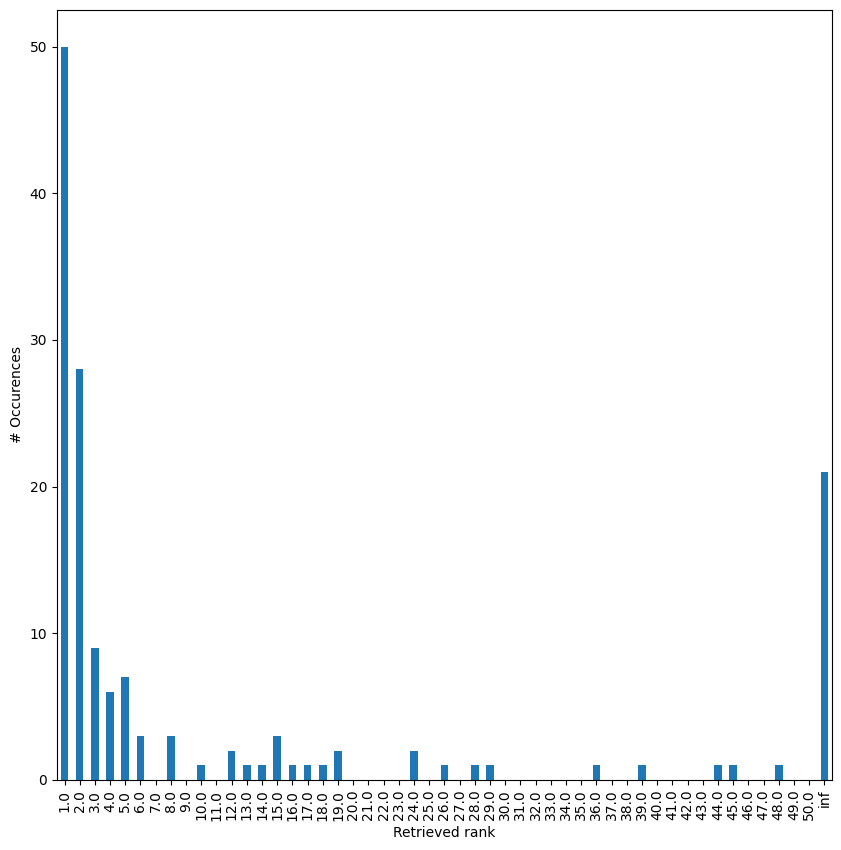

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

ranks = results['doc_rank'].value_counts() # .sort_index()

# Add all positions between 0 and 50
new_index = list(range(50))
new_index.append(float("inf"))
ranks = ranks.reindex(new_index, fill_value=0)

# ranks are indexed at 0. Display ranks indexed at 1 instead.
ranks.index = ranks.index + 1

ranks.plot(kind="bar")

_ = plt.ylabel("# Occurences")
_ = plt.xlabel("Retrieved rank")

### Recall at K

The first metric we will look at it Recall@K. It will help us determine Buster's retrieval abilities.

As a reminder, Recall@K, for a single retrieval, is measured by computing:

    # (positive instances retrieved at K documents) / # (total positive instances)


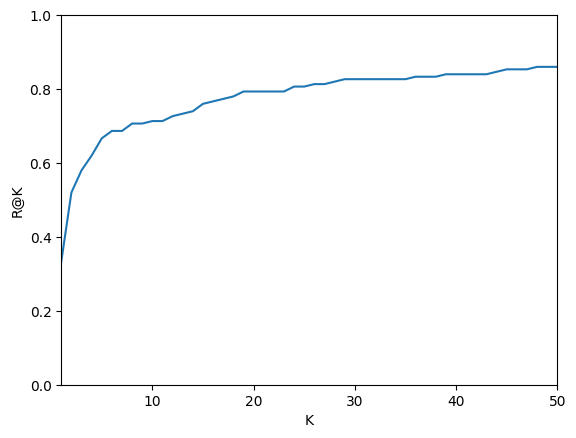

R@1: 0.3333333333333333
R@2: 0.52
R@3: 0.58
R@4: 0.62
R@5: 0.6666666666666666


In [5]:
from src.evaluation.recall_at_k import recall_at_k


# Index at 1
recall_at_k_results = {k + 1: recall_at_k(results, k, column="doc_rank") for k in range(50)}

# recall_at_k_results[100] = 1

# plt.figure()
fig = plt.plot(recall_at_k_results.keys(), recall_at_k_results.values())
ax = plt.gca()
ax.set_ylim([0, 1])
ax.set_xlim([1, 50])

plt.ylabel("R@K")
plt.xlabel("K")

plt.show()

for k in range(1, 6):
    print(f"R@{k}: {recall_at_k_results[k]}")


Note that this can essentially be interpreted as:

For 1/3 of questions, the top document retrieved is the correct one. ~60% of the time, the relevant document is found in the top 3 retrieved.

One concerning observation is the number of `+inf` , which in our case represents instances where the proper document was not retrieved.

When looking at the documents in question, it becomes apparent that the uniform choice of the documents can be an issue. For example:

In [6]:
with pd.option_context('display.max_colwidth', None):
    display(results[results.doc_rank == float("inf")])

,document,question,doc_rank
57,"These included the highly intrusive level of biometric data being demanded, the compulsory nature of the plan, criminal sanc- tions for non-compliance, and the absence of adequate safeguards for data protection. The sce- nario that emerged by 2019 was one in which AI was being used to undermine the privacy rights, 1 Chief Justice Sykes, Para 23 of the Supreme Court Ruling on the National Identification and Registration Act. supremecourt.gov.jm/ content/robinson-julian-v-attorney-general-jamaica personal choices and constitutional freedoms of an entire population. In April 2019, the Jamaican Supreme Court largely agreed with the expressed concerns and handed down a historic ruling, designating the new NIRA law “null, void and of no effect”. 2 Legislative context Jamaica is a parliamentary democracy that gained political independence from Britain some 57 years ago, in 1962. Since then, two major political par- ties, the currently ruling Jamaica Labour Party (JLP) and the opposition People’s National Party (PNP), have alternated power, both claiming strong affinity to democracy and the rule of law. The apex of the judicial system is still the United Kingdom Privy Council, but the country’s Supreme Court, headed by an independent chief justice, serves as the top court of original jurisdiction. The Supreme Court in- cludes a constitutional division. Jamaica’s independence constitution was amended with bi-partisan support in April 2011 to include a Charter of Fundamental Rights and Free- doms, which established or strengthened a range of key citizen protections. Among other provisions, the Charter specifies that “Parliament shall pass no law and no organ of the state shall take any action which abrogates, abridges or infringes the guar- anteed rights”.",What were the main concerns regarding the collection of biometric data in the proposed plan?,inf
60,"1 F/n 1: For greater certainty, for the purposes of this section, a “product” is a good and does not include a financial instrument. 2. For the purposes of this section: cryptography means the principles, means or methods for the transformation of data in order to hide its information content, prevent its undetected modification or prevent its unauthorised use; and is limited to the transformation of information using one or more secret parameters, for example, crypto variables, or associated key management; encryption means the conversion of data (plaintext) into a form that cannot be easily understood without subsequent re-conversion (ciphertext) through the use of a cryptographic algorithm; cryptographic algorithm or cipher means a mathematical procedure or formula for combining a key with plaintext to create a ciphertext; and key means a parameter used in conjunction with a cryptographic algorithm that determines its operation in such a way that an entity with knowledge of the key can reproduce or reverse the operation, while an entity without knowledge of the key cannot. 3.",What is the difference between a product and a financial instrument in the context of AI policies?,inf
61,"1 F/n 1: For greater certainty, for the purposes of this section, a “product” is a good and does not include a financial instrument. 2. For the purposes of this section: cryptography means the principles, means or methods for the transformation of data in order to hide its information content, prevent its undetected modification or prevent its unauthorised use; and is limited to the transformation of information using one or more secret parameters, for example, crypto variables, or associated key management; encryption means the conversion of data (plaintext) into a form that cannot be easily understood without subsequent re-conversion (ciphertext) through the use of a cryptographic algorithm; cryptographic algorithm or cipher means a mathematical procedure or formula for combining a key with plaintext to create a ciphertext; and key means a parameter used in conjunction w

In [7]:
import pandas as pd

from src.evaluation.relevant_answers import compute_result

    
results_df = pd.read_csv("./question_answer_results.csv")

for question_type in ["relevant", "irrelevant", "trick"]:
    results = compute_result(results_df, question_type)
    print(f"Result for {question_type=}: {sum(results)}/{len(results)}")

Result for question_type='relevant': 56/65
Result for question_type='irrelevant': 30/30
Result for question_type='trick': 26/34


In [8]:
# Here we display the relevant questions that were not answered:

with pd.option_context('display.max_colwidth', None):
    sub_df = results_df[results_df.question_type == "relevant"]
    sub_df = sub_df[sub_df.answer_relevant == False]
    display(sub_df[["question", "answer"]])

,question,answer
3,How many African countries have a national AI strategy?,"According to the provided documents, the number of African countries with a national AI strategy is not specified. Therefore, I cannot answer this question based on the information I have available."
23,"What are the strengths, weaknesses, opportunities and threats of Ireland’s AI ecosystem?",I cannot answer this question based on the information I have available.
24,In what way does Canada implement the OECD AI Principles?,The provided documents do not directly address how Canada implements the OECD AI Principles. I cannot answer this question based on the information I have available.
54,Are there any AI regulatory sandboxes in Spain?,I cannot answer this question based on the information I have available.
55,Are there any AI regulatory sandboxes in Japan?,I cannot answer this question based on the information I have available.
57,What is the timeline of Slovenia’s implementation of its national AI strategy?,"I'm sorry, but I cannot answer this question based on the information I have available."
58,What is the timeline of Korea’s implementation of its national AI strategy?,The timeline of Korea's implementation of its national AI strategy is not provided in the documents. I cannot answer this question based on the information I have available.
59,In which year has the second phase of France’s national AI strategy started?,"The provided documents do not specify the exact year in which the second phase of France's national AI strategy started. Therefore, I cannot answer this question based on the information I have available."
66,Which legislation in Japan applies to AI?,"The provided documents do not specify the legislation in Japan that specifically applies to AI. Therefore, I cannot answer this question based on the information I have available."


In [9]:
# Here we display the trick questions that were answered:

with pd.option_context('display.max_colwidth', None):
    sub_df = results_df[results_df.question_type == "trick"]
    sub_df = sub_df[sub_df.answer_relevant == True]
    display(sub_df[["question", "answer"]])

,question,answer
98,"To what extent does China's Personal Information Protection Law align with international data protection standards, such as the EU's General Data Protection Regulation (GDPR)?","China's Personal Information Protection Law (PIPL) introduces restrictions on cross-border data transfers that differ from international privacy regimes such as the EU's GDPR. While the GDPR and PIPL appear to have similar cross-border transfer tests, there are material differences. The PIPL does not provide for derogations or mechanisms such as Binding Corporate Rules and standard data protection clauses for companies to gain approval, which are found in the GDPR. Additionally, data localization laws in China may increase compliance costs for companies engaged in data collection from different countries. Therefore, while the PIPL addresses personal information protection, it does not align completely with international data protection standards like the GDPR."
99,How does the United Kingdom's AI Sector Deal support the development of small and medium-sized AI enterprises?,"The United Kingdom's AI Sector Deal aims to support the development of small and medium-sized AI enterprises by providing funding opportunities and improving access to investment. The deal recommends reserving a proportion of the £2.5 billion investment fund at the British Business Bank as an AI growth fund specifically targeted at enabling SMEs with a substantive AI component to scale up their business. Additionally, the deal encourages the government to consult on the need to improve access to funding within the UK for SMEs with a substantive AI component looking to scale their business."
104,How does Australia's Consumer Data Right (CDR) ensure that consumers can effectively exercise control over their personal data when it is used in AI applications?,"The Consumer Data Right (CDR) in Australia aims to empower consumers by giving them the right to safely access their personal data and authorize its transfer to third parties. The CDR focuses on the consumer's choice and ability to share their data, rather than a business's right to share consumer data. While the specific application of the CDR to AI applications is not mentioned in the provided documents, it can be inferred that the CDR would apply to personal data used in AI applications. This means that consumers would have the right to control and authorize the use of their personal data in AI applications, ensuring that they can effectively exercise control over their data in this context."
110,"To what extent does the Data Privacy and AI Regulation Act in South Africa align with international data protection standards, such as the EU's General Data Protection Regulation (GDPR)?","Based on the provided documents, there is no specific information about the alignment between the Data Privacy and AI Regulation Act in South Africa and international data protection standards such as the EU's GDPR. Therefore, I cannot answer this question based on the information I have available."
113,How does Egypt's AI National Strategy aim to build a strong AI research and development infrastructure while fostering international partnerships?,"Egypt's AI National Strategy aims to build a strong AI research and development infrastructure while fostering international partnerships through several key approaches:\n\n1. Comprehensive national plan: The National Council for Artificial Intelligence has been mandated to develop a comprehensive national plan that paves the way for indigenizing the AI industry and strengthening Egypt's leading role at the regional level. This plan promotes effective partnerships between the government and the private sectors to create a dynamic work environment that spurs innovation and supports the digital transformation led by AI applications.\n\n2. Encouraging investment in R&D: The strategy emphasizes the importance of investment in research and development in AI technologies. By encouraging inve